# Notebook to load and play around with the data
Load ramete lists and pedigree data. Plays around with them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from time import time

In [2]:
in_fld = "./Input/"      # Input Folder
out_fld = "./Output/"    # Output Folder
years = list(range(2010,2017))# Make List of all Years
fls = [("pedigree_" + str(i) + "_Loci95.csv") for i in years]  # File Names

geo_fl = "FinalGenoEcol_short_int.csv"  # The Path to the GPS File. Uses track scores, geno scores & 

In [3]:
# Load the SNPPit Results:

### Load the Pedigree as concatenated over the years
df_p = pd.read_csv(in_fld + fls[0], sep=",", index_col=0)

for i in range(1, len(fls)):
    df_t = pd.read_csv(in_fld + fls[i], sep=",", index_col=0)              # Enter the Year
    assert(np.sum(df_p.columns != df_t.columns)==0) # Check if anymismatch
    df_p = pd.concat([df_p, df_t])

# Extract the interesting columns:


print("Loaded Pedigree dataframe: %i raws" % len(df_p))
print(df_p.year_kid.value_counts())

#df_p = df_p Extract only interesting Columns

# Load the GPS data:
df_geo = pd.read_csv(in_fld + geo_fl, sep=",")
df_t = df_geo
# Extract interesting summary stats:
cols = ["PlantID_final", "RametIDs", "Easting", "Northing", "Altitude", "Score_phase1", "GenoScore", "FirstYear"]
alive_cols = ["AliveRec_" + str(i) for i in range(2009,2017)]

df_geo = df_geo[cols + alive_cols]  # Extract interesting columns

print("Loaded Nr of Ramets: %i" % len(df_geo))
print("Loading complete!!")

# Merge in datatable of kid,pa & ma with scores, positions and years alive
df = pd.merge(df_p, df_geo, left_on="Kid", right_on="PlantID_final", how='left', suffixes=('', '_kid'))
df = pd.merge(df, df_geo, left_on="Ma", right_on="PlantID_final", how='left', suffixes=('', '_Ma'))
df = pd.merge(df, df_geo, left_on="Pa", right_on="PlantID_final", how='left', suffixes=('', '_Pa'))

print("\nFull data table produced: %i raws, %i cols" % np.shape(df))
print("Dataframe found in df")

Loaded Pedigree dataframe: 1476 raws
2014    669
2013    288
2016    256
2015    220
2012     32
2011     11
Name: year_kid, dtype: int64
Loaded Nr of Ramets: 19910
Loading complete!!

Full data table produced: 1476 raws, 88 cols
Dataframe found in df


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (276,277,279,280,281,282,283,284,285,291,292,294,295,296,297,298,299,300,306,307,309,310,311,312,313,314,315,336,337,339,340,341,342,343,344,345,355,356,357,359,360,401,402,403,412) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Plot Dispersal Distances across the years

In [4]:
### Extract Fractions of possible Ancestor Distance Bins:
def calc_distance_matrix(coords):
    '''Calculate the distance matrix between all coords. Requires numpy array of 2d coordinates'''
    print("Calculating distance matrix")
    start = time()
    dist_mat = np.linalg.norm(coords[:, None] - coords, axis=2)
    print("Finished Calc. Time taken %.2f" % (time() - start))
    return dist_mat


df_t = df_geo[(df_geo.GenoScore>=1) & (df_geo.Score_phase1>4)] # Extract good Values
pw_dists=calc_distance_matrix(df_t[["Easting","Northing"]].values) # Hard on the boundary what is possible

dists = pw_dists[np.triu_indices(len(pw_dists), k = 1)]
print("Median pw. Dist: %.4f" % np.median(dists))

Calculating distance matrix
Finished Calc. Time taken 14.57
Median pw. Dist: 891.7050


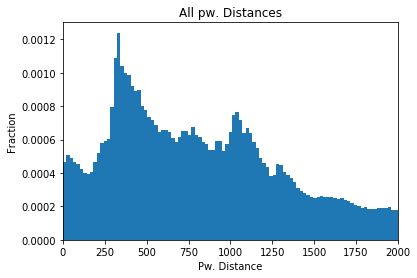

In [6]:
### Quick plot of all pairwise Distances
plt.figure()
plt.hist(dists, bins=np.linspace(0,2000,100), density=True)
plt.xlabel("Pw. Distance")
plt.ylabel("Fraction")
plt.title("All pw. Distances")
plt.xlim([0,2000])
plt.show()

# Raw Dispersal
Analyze Dispersal of all raw detected pairs.

# Analyze Dispersal Distances:

Do various statistics of the Dispersal Distances

In [8]:
d = np.concatenate([df.Dist_ma, df.Dist_pa])
d = d[d<3000]

def print_summ_stat(d, cutoff=3000):
    """Print Summary Statistics"""
    print("%i Entries >%.1f m cut" % (np.sum(d>cutoff), cutoff))
    d = d[d<cutoff]
    
    print("Nr of Entries: %i" % len(d))
    print("Mean: \t%.3f m" % np.mean(d))
    print("Med: \t%.3f m" % np.median(d))
    print("Std: \t%.3f m" % np.std(d))
    
def analyze_dispersal(df, cutoff=3000, col=""):
    """Analyze Dispersal for Dataframe df
    Print various Summary statistics
    cutoff: Max Distance to analyze
    Input: Dataframe
    Output: None"""
    if len(col)==0:
        d = np.concatenate([df.Dist_ma, df.Dist_pa])  
    else: d= df[cols]
        
    print_summ_stat(d, cutoff)

def do_axis(df, norm=True, cutoff=3000):
    """Do Dispersal Estimates along axis."""
    # Do Dispersal on the x-axis
    delx_ma = df.Easting - df.Easting_Ma
    dely_ma = df.Northing - df.Northing_Ma
    delx_pa = df.Easting - df.Easting_Pa
    dely_pa = df.Northing - df.Northing_Pa
    delalt_ma = df.Altitude - df.Altitude_Ma
    delalt_pa = df.Altitude - df.Altitude_Pa

    delx = np.concatenate([delx_ma, delx_pa])
    dely = np.concatenate([dely_ma, dely_pa])
    delalt = np.concatenate([delalt_ma, delalt_pa])
    
    if norm==True:
        delx,dely,delat=np.abs(delx),np.abs(dely),np.abs(delalt)
        
    print("\nX-Axis:")
    print_summ_stat(delx, cutoff=cutoff)

    print("\nY-Axis:")
    print_summ_stat(dely, cutoff=cutoff)

    print("\n Altitude:")
    print_summ_stat(delalt, cutoff=cutoff)
    
    return (delx, dely)

def extract_dists(df, ids_pa, ids_ma):
    """Extract IDs from Pa & Ma"""
    d_pa = df.Dist_ma[ids_ma]
    d_ma = df.Dist_pa[ids_pa]
    return np.concatenate([d_pa, d_ma])

def normalization(bins, dists, counts):
    """Creates the Normalization for bins
    bins: 1D Array of Bins
    dist: 1D Array of all possible distances
    counts: 1D Array of Actual Counts"""
    
    assert(len(bins)>1) # Sanity Check
    dens_dis, _ = np.histogram(dists, bins = bins, density=False)
    dens_count, _ = np.histogram(counts, bins = bins, density=False)
    frac_real = (dens_count/dens_dis)
    
    return frac_real # Fraction realized in each bin

## Estimate raw Dispersal Curve

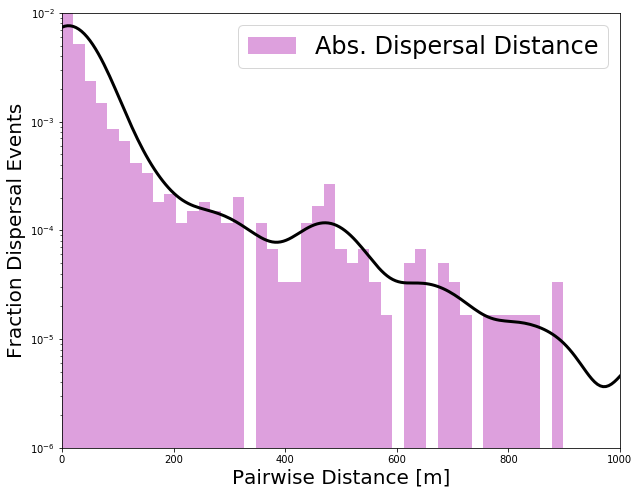

In [10]:
### Estimate raw Dispersal curve
f=stats.gaussian_kde(df.Dist_pa)
g=stats.gaussian_kde(df.Dist_ma)

d = np.concatenate([df.Dist_ma, df.Dist_pa])
h = stats.gaussian_kde(d)

x=np.linspace(0,1000,200)
plt.figure(figsize=(10,8))

#plt.hist(df.Dist_pa, bins = 50, density=True, label="Dist Pa", alpha=0.5, color="skyblue")
#plt.hist(df.Dist_ma, bins = 50, density=True, label="Dist Ma", color="red", alpha=0.5)
bins=np.linspace(0,1000,50)
plt.hist(d, bins = bins, density=True, label="Abs. Dispersal Distance", 
         color="plum", alpha=1.0)

fs=20
plt.plot(x, h(x), color="k", linewidth=3)

plt.ylim([0.000001,0.01])
plt.xlim([0,1000])
plt.legend(fontsize=24)
plt.xlabel("Pairwise Distance [m]", fontsize=fs)
plt.ylabel("Fraction Dispersal Events", fontsize=fs)
plt.yscale("log")
plt.show()

## Plot corrected Dispersal

[0.00668852 0.00195767 0.0008383  0.00057279 0.00030723 0.00027905
 0.00019919 0.00020166 0.00015561 0.00013403]


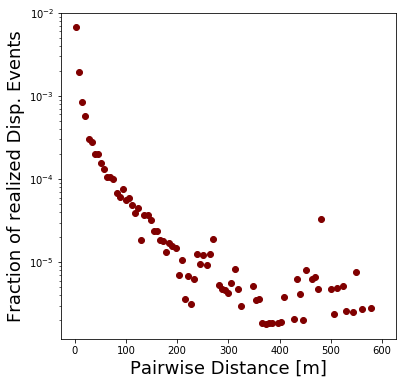

In [19]:
### Plot corrected Dispersal
bins = np.linspace(0, 600, 100)
mid_bin = (bins[1:]+bins[:-1])/2.0

fracs = normalization(bins, dists, d)   # Calculate Normalization
print(fracs[:10])

fs=18

plt.figure(figsize=(6,6))
plt.plot(mid_bin, fracs, "o", color="maroon")
plt.ylabel("Fraction of realized Disp. Events", fontsize=fs)
plt.xlabel("Pairwise Distance [m]", fontsize=fs)
plt.yscale("log")
plt.show()

Dispersal Distance:
4 Entries >3000.0 m cut
Nr of Entries: 2948
Mean: 	46.606 m
Med: 	7.807 m
Std: 	142.534 m

X-Axis:
4 Entries >3000.0 m cut
Nr of Entries: 2948
Mean: 	-3.739 m
Med: 	-0.648 m
Std: 	129.160 m

Y-Axis:
0 Entries >3000.0 m cut
Nr of Entries: 2952
Mean: 	-1.710 m
Med: 	-0.421 m
Std: 	82.274 m

 Altitude:
0 Entries >3000.0 m cut
Nr of Entries: 2952
Mean: 	19.471 m
Med: 	1.925 m
Std: 	35.198 m


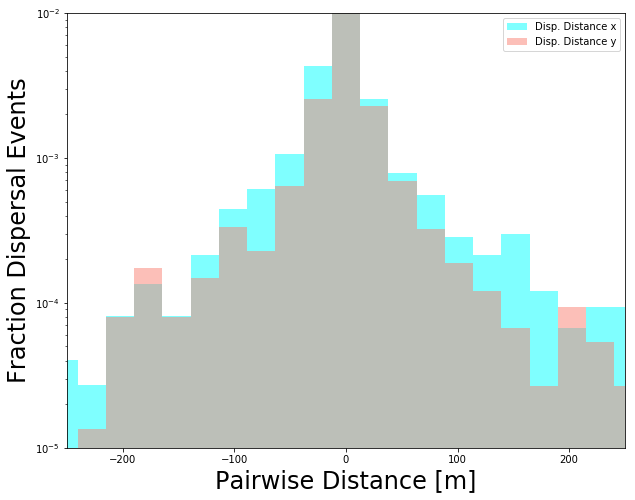

In [20]:
# Do some Dispersal Analysis

print("Dispersal Distance:")
analyze_dispersal(df, cutoff=3000)
delx, dely = do_axis(df, norm=False)
bins = np.linspace(-1000,1000,80)

fs=24
plt.figure(figsize=(10,8))
plt.hist(delx, bins = bins, density=True, label="Disp. Distance x", color="aqua", alpha=0.5)
plt.hist(dely, bins = bins, density=True, label="Disp. Distance y", color="salmon", alpha=0.5)
#plt.plot(x, h(x), color="k", linewidth=3)

plt.ylim([0.00001,0.01])
plt.xlim([-250,250])
plt.legend()
plt.xlabel("Pairwise Distance [m]", fontsize=fs)
plt.ylabel("Fraction Dispersal Events", fontsize=fs)
plt.yscale("log")
plt.show()
#print("Correlation Along axis: %.4f" % np.corrcoef([delx, dely])[1,0])
# Do Dispersal on the y-axis

# Plot Dispersal Distances across minimum Geo score

Bad/Fair/Excellent Geo Scores:
2 Entries >3000.0 m cut
Nr of Entries: 678
Mean: 	80.614 m
Med: 	7.488 m
Std: 	224.257 m
0 Entries >3000.0 m cut
Nr of Entries: 1868
Mean: 	37.483 m
Med: 	7.934 m
Std: 	106.980 m
0 Entries >3000.0 m cut
Nr of Entries: 179
Mean: 	24.177 m
Med: 	7.857 m
Std: 	53.602 m


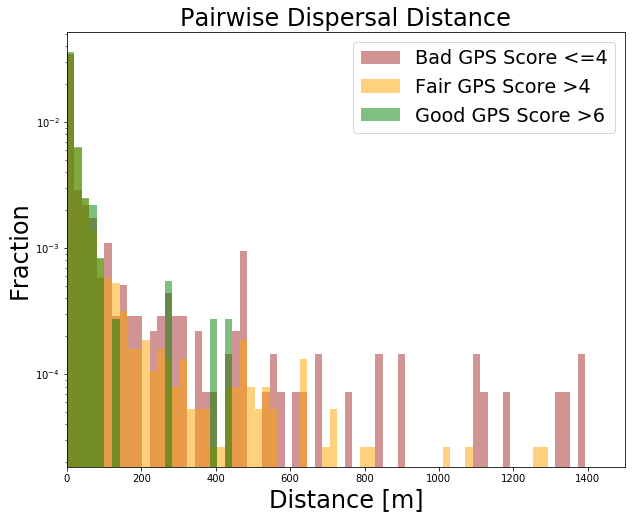

[2.85900819e-03 5.55732474e-04 3.15405296e-04 1.87791787e-04
 1.16482497e-04 8.97301590e-05 5.75832539e-05 6.47763178e-05
 3.87067120e-05 3.59520831e-05]


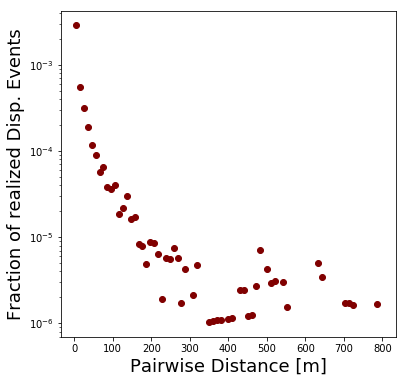

In [39]:
#df_geo.Score_phase1.value_counts()
min_score_ma = np.minimum(df.Score_phase1_Ma, df.Score_phase1)
min_score_pa = np.minimum(df.Score_phase1_Pa, df.Score_phase1)

# Extract Raws
shit_ids_ma, shit_ids_pa = min_score_ma<4, min_score_pa<4
fair_ids_ma, fair_ids_pa = min_score_ma>=5, min_score_pa>=5
excellent_ids_ma, excellent_ids_pa = min_score_ma>6, min_score_pa>6

d_shit = extract_dists(df, shit_ids_pa, shit_ids_ma)
d_fair = extract_dists(df, fair_ids_pa, fair_ids_ma)
d_exc = extract_dists(df, excellent_ids_pa, excellent_ids_ma)

print("Bad/Fair/Excellent Geo Scores:")
print_summ_stat(d_shit)
print_summ_stat(d_fair)
print_summ_stat(d_exc)

#### Parameters for the Plot
bins=np.linspace(0,2000,100)
a=0.5 # Alpha
fs=24

#### Actual Figure
plt.figure(figsize=(10,8))
plt.hist(d_shit, bins=bins, color="brown", density=True, alpha=a, label="Bad GPS Score <=4")
plt.hist(d_fair, bins=bins, color="orange", density=True, alpha=a, label="Fair GPS Score >4")
plt.hist(d_exc, bins=bins, color="green", density=True, alpha=a, label="Good GPS Score >6")
plt.yscale("log")
plt.xlim([0,1500])
plt.xlabel("Distance [m]", fontsize=fs)
plt.ylabel("Fraction", fontsize=fs)
plt.legend(fontsize=fs*0.8)
plt.title("Pairwise Dispersal Distance", fontsize=fs)
plt.savefig("./Figures/gps_score_disp.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()


### Do the normalized Dispersal Kernel
### Plot corrected Dispersal
bins = np.linspace(0, 800, 80)
mid_bin = (bins[1:]+bins[:-1])/2.0

fracs = normalization(bins, dists, d_fair)   # Calculate Normalization


fs=18

plt.figure(figsize=(6,6))
plt.plot(mid_bin, fracs, "o", color="maroon")
plt.ylabel("Fraction of realized Disp. Events", fontsize=fs)
plt.xlabel("Pairwise Distance [m]", fontsize=fs)
plt.yscale("log")
plt.savefig("./Figures/dispersal_curve_antirrhinum.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Do the Dispersal across year:

In [42]:
np.sum(d_fair>200)/len(d_fair)

0.04068522483940043

# Area 51

In [ ]:
analyze_dispersal(df, cutoff=3000)

In [ ]:
plt.figure()

_, bins, _ = plt.hist(x, density=True, bins=100)
plt.plot(bins, f(bins), "r-")

plt.show()

In [41]:
100/np.sqrt(2)

70.71067811865474